In [1]:
## This is an implementation of the 3d spring loaded inverted pendulum environment
## Author: Avadesh Meduri
## Date : 9/06/2020

import numpy as np

import IPython
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [85]:
'''
This is an implementation of the 3d SLIP environment for training the DQ stepper
'''

class SLIPEnv:
    
    def __init__(self, l0, b, k, max_step_length, w, no_actions = [11, 9]):
        '''
        Input:
            l0 : nominal leg length of spring
            b : width of base
            k : spring stiffness
            max_step_length : maximum step length
            w : wieghts for the cost function
            no_actions : discretization of actions
        '''
        self.g = 9.81
        self.dt = 0.001
        self.l0 = l0
        self.b = b
        self.k = k
        assert len(w) == 3
        self.w = w
        # The difference between the center of mass and hip 
        self.com_offset = 0.0
        self.no_steps = 0
        
        assert len(no_actions) == 2
        # The co ordinate axis is x : forward and y : sideways walking, z : faces upward
        # This means that left leg is on the positive side of the y axis
        # The addition b is added to accomodate a step length larger than leg length as it may be feasible
        # in high velocity cases.
        self.action_space_x = np.around(np.linspace(-max_step_length, max_step_length, no_actions[0]), 2)
        # actions to the free side
        if b > 0 :
            self.action_space_ly = np.geomspace(b, max_step_length + b, int(2*no_actions[1]/3))
            # actions to the non free side where leg can hit the other leg
            # Y axis actions step length allowed such that robot can't step to the left of the left leg
            # or the right to the right leg (no criss crossing)
            self.action_space_ry = np.linspace(0, b, int(no_actions[1]/3), endpoint = False)
            self.action_space_y = np.around(np.concatenate((self.action_space_ry, self.action_space_ly)), 2)
        else:
            self.action_space_y = np.around(np.linspace(0, max_step_length, int(no_actions[1])), 2)
        
        self.t = 0
        self.max_step_height = 0.09
        
    def stance_dynamics(self, x_t, u_t):
        '''
        returns dynamics of the system in stance
        '''
        dx = np.zeros(6)
        if np.linalg.norm([x_t[0] - u_t[0], x_t[1] - u_t[1]]) == 0:
            th = np.arctan(np.inf)
            ph = th
        else:
            th = np.arctan((x_t[1] - u_t[1])/(x_t[0] - u_t[0]))
            if th < 0:
                th = np.pi + th
            ph = np.arctan((x_t[2] - u_t[2])/(np.linalg.norm([x_t[0] - u_t[0], x_t[1] - u_t[1]])))
        
        dx[0:3] = x_t[3:6]
        l = np.linalg.norm(np.subtract(x_t[0:3], u_t))
        dx[3] = -self.k*(l - self.l0)*np.cos(ph)*np.cos(th)
        dx[4] = -self.k*(l - self.l0)*np.cos(ph)*np.sin(th)
        dx[5] = -self.k*(l - self.l0)*np.sin(ph) - self.g
        
        return np.array(dx)
    
    def flight_dynamics(self, x_t):
        '''
        returns dynamics of the system in flight
        '''
        dx = np.zeros(6)
        dx[0:3] = x_t[3:6]
        dx[5] = -self.g
    
        return np.array(dx)
    
    def integrate_stance_dynamics(self, x_t, u_t):
        '''
        This function integrates the SLIP model by one timestep when it is stance phase
        Input:
            x_t: current state of the robot [x, y, z, xd, yd, zd]
            u_t : COP location at current time step [ux, uy, uz]
        '''
        x_t_1 = np.zeros(6)
    
        k1 = self.stance_dynamics(x_t, u_t)
        k2 = self.stance_dynamics(x_t + 0.5*self.dt*k1, u_t)
        k3 = self.stance_dynamics(x_t + 0.5*self.dt*k2, u_t)
        k4 = self.stance_dynamics(x_t + self.dt*k3, u_t)
        
        tmp = self.dt*(k1 + 2*k2 + 2*k3 + k4)/6
        
        return np.add(x_t, tmp)  
        
    def integrate_flight_dynamics(self, x_t):
        '''
        This function integrates SLIP model by one timestep when in flight phase
        Input:
            x_t: current state of the robot [x, y, z, xd, yd, zd]
        '''
        x_t_1 = np.zeros(6)
        
        k1 = self.flight_dynamics(x_t)
        k2 = self.flight_dynamics(x_t + 0.5*self.dt*k1)
        k3 = self.flight_dynamics(x_t + 0.5*self.dt*k2)
        k4 = self.flight_dynamics(x_t + self.dt*k3)
        
        tmp = self.dt*(k1 + 2*k2 + 2*k3 + k4)/6
        
        return np.add(x_t, tmp)  
        
    def reset_env(self, x0, v_des, epi_steps):
        '''
        This function resets the env
        Input:
            x0: initial state
            v_des : desired velocity
            epi_steps: no_steps to be simulated
        '''
        self.epi_steps = epi_steps
        assert len(x0) == 5
        self.t = 0
        self.v_des = v_des
        # [x, y, z, xd, yd, zd, ux, uy, uz, n]
        self.sim_data = np.zeros((11, epi_steps*int(0.5/self.dt))) # 0.5 is a nominal step time (not imp)
        assert np.linalg.norm(x0[0:3]) < self.l0
        self.sim_data[:,self.t][0:5] = x0
        self.sim_data[:,self.t][7] = -self.b/2 # right leg on the ground
        self.sim_data[:,self.t][9] = 1 # determines which leg is on the ground (1 is right leg)
        self.sim_data[:,self.t][10] = 1 # 1 implies in stance 0 is in flight

        processed_state = np.zeros(8)
        processed_state[0:6] = np.take(self.sim_data[:,0], [0, 1, 2, 3, 4, 9])
        processed_state[6:8] = self.v_des    
        
        return processed_state
    
    def step_env(self, action):
        '''
        This function integrates SLIP model starting from the time it lands to 
        the next landing point.
        Input:
            action : next step location
        '''
        assert action[2] < self.max_step_height
        self.i = 0 #safety check which terminates if step length is more than 1 sec
        while not self.isdone(action) or self.sim_data[:,self.t][10]:
            self.i += 1
            if np.shape(self.sim_data)[1] < self.t + 50:
                self.sim_data = np.concatenate((self.sim_data, np.zeros((11, 100))), axis = 1)
            if self.sim_data[:,self.t][10]:
                if np.linalg.norm(np.subtract(self.sim_data[:,self.t][0:3], self.sim_data[:,self.t][6:9])) < self.l0 or \
                        np.linalg.norm(np.subtract(self.sim_data[:,self.t][0:3], self.sim_data[:,self.t][6:9])) == self.l0:

                    self.sim_data[:,self.t+1][0:6] = self.integrate_stance_dynamics(self.sim_data[:,self.t][0:6]\
                                                                               , self.sim_data[:,self.t][6:9])
                    self.sim_data[:,self.t+1][6:9] = self.sim_data[:,self.t][6:9] # u
                    self.sim_data[:,self.t+1][9] = self.sim_data[:,self.t][9] #n
                    self.sim_data[:,self.t+1][10] = self.sim_data[:,self.t][10] #n
                    self.t += 1
                else:
                    self.sim_data[:,self.t][6] += self.action_space_x[action[0]]
                    self.sim_data[:,self.t][7] += self.sim_data[:,self.t][9]*self.action_space_y[action[1]]
                    self.sim_data[:,self.t][8] += action[2]
                    self.sim_data[:,self.t][9] = -1*self.sim_data[:,self.t][9]
                    self.sim_data[:,self.t][10] = 0

            else:
                if np.linalg.norm(np.subtract(self.sim_data[:,self.t][0:3], self.sim_data[:,self.t][6:9])) > self.l0:
                    self.sim_data[:,self.t+1][0:6] = self.integrate_flight_dynamics(self.sim_data[:,self.t][0:6])
                    self.sim_data[:,self.t+1][6:9] = self.sim_data[:,self.t][6:9] # u
                    self.sim_data[:,self.t+1][9] = self.sim_data[:,self.t][9] #n
                    self.sim_data[:,self.t+1][10] = self.sim_data[:,self.t][10] # in flight
                    self.t += 1
                    
                else:
                    self.sim_data[:,self.t][10] = 1 # in stance
                    break
                    
        ## modifying state that is returned is such that the origin is u0 instead of the global origin
        ## This ensures that the state x[0] is bounded by the maximum leg size while collecting data
        processed_state = np.zeros(8)
        processed_state[0:6] = np.take(self.sim_data[:,self.t], [0, 1, 2, 3, 4, 9])
        processed_state[0:3] -= self.sim_data[:,self.t][6:9] # shifting origin to u
        processed_state[6:8] = self.v_des    
        
        if not self.isdone(action):
            self.no_steps += 1
        
        return np.round(processed_state, 2), self.compute_cost(action), self.isdone(action)
    
    def isdone(self, action):
        if self.sim_data[:,self.t][2] < self.l0/10.0:
            u = self.sim_data[:,self.t][6:9].copy()
            u[0] += self.action_space_x[action[0]]
            u[1] += self.sim_data[:,self.t][9]*self.action_space_y[action[1]]
            u[2] += action[2]
            if np.linalg.norm(np.subtract(self.sim_data[:,self.t][0:3], u)) > self.l0:
                return True
            else:
                return False
        elif self.i > 1000:
            return True
        else:
            return False
    
    def compute_cost(self, action):
        return 0
    
    def show_episode(self, freq):
        '''
        Shows animation
        Input :
            freq : frame rate
        '''
        sim_data = self.sim_data[:, 0:self.t]
        sim_data = sim_data[:,::freq]

        fig = plt.figure()
        ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))
        text_str = "top view of IPM"
        base, = ax.plot([], [], lw=3, color = 'blue')
        leg, = ax.plot([], [], lw=3, color = 'pink')
        com, = ax.plot([], [], 'o', color='red')
        foot, = ax.plot([], [], 'o', color='green')

        
        def init():
            base.set_data([], [])
            leg.set_data([], [])
            com.set_data([], [])
            foot.set_data([], [])
            return base, leg, com, foot
        
        def animate(i):
            x_com = sim_data[:,i][0]
            y_com = sim_data[:,i][1]
            u_x = sim_data[:,i][6]
            u_y = sim_data[:,i][7]
            n = sim_data[:,i][9]
            
            base.set_data([x_com, x_com], [y_com - self.b/2, y_com + self.b/2])
            leg.set_data([x_com, u_x], [y_com - n*(self.b/2), u_y])
            com.set_data([x_com], [y_com])
            foot.set_data([u_x], [u_y])
            return base,leg, com, foot
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
        
        anim = FuncAnimation(fig, animate, init_func=init,
                                       frames=np.shape(sim_data)[1], interval=25, blit=True)
        plt.grid()
        plt.close(fig)
        plt.close(anim._fig)
        IPython.display.display_html(IPython.core.display.HTML(anim.to_html5_video()))
        
    def show_episode_side(self, freq):
        '''
        shows animation from the side view
        Input:
            freq : frame rate
        '''
        sim_data = self.sim_data[:, 0:self.t]
        sim_data = sim_data[:,::freq]

        fig = plt.figure()
        ax = plt.axes(xlim=(-2, 2), ylim=(-0.2, 0.5))
        text_str = "side view (xz plane)"
        leg, = ax.plot([], [], lw=4)
        body, = ax.plot([], [], lw=4)
        head, = ax.plot([], [], 'o', color='green')
        com, = ax.plot([], [], 'o', color='red')
        foot, = ax.plot([], [], 'o', color='pink')
        
        def init():
            leg.set_data([], [])
            body.set_data([], [])
            head.set_data([], [])
            com.set_data([], [])
            foot.set_data([], [])
            
            return leg, body, head, com, foot
        
        def animate(i):
            x = sim_data[:,i][0]
            y = sim_data[:,i][2]
            if sim_data[:,i][10] == 1:
                ux = sim_data[:,i][6]
                uy = sim_data[:,i][8]
            else:
                ux = x
                uy = y
            
            leg.set_data([ux,x], [uy,y - self.com_offset])
            com.set_data([x, y])
            body.set_data([x, x], [y, y - self.com_offset])
            head.set_data([x, y])
            foot.set_data([ux, uy])

            return leg, com, body, head, foot
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
        
        anim = FuncAnimation(fig, animate, init_func=init,
                                       frames=np.shape(sim_data)[1], interval=25, blit=True)

        plt.close(fig)
        plt.close(anim._fig)
        IPython.display.display_html(IPython.core.display.HTML(anim.to_html5_video()))


In [90]:
show = True

if show:
    no_steps = 8
    
    env = SLIPEnv(0.2, 0, 800, 0.22, [0, 0, 1], [11, 1])
    state = env.reset_env([0, 0, 0.15, 1., 0], [0, 0], no_steps)
#     action_arr = [4, 10, 10, 7, 7, 7, 7, 7]
    action_arr = [10, 10, 10, 10, 5, 8, 7, 10]
    for t in range(no_steps):
        action = [action_arr[t], 0, 0]        
        next_state, cost, done = env.step_env(action)
        print(state, action, cost, done)
        state = next_state
        
    env.show_episode_side(10)

[0.   0.   0.15 1.   0.   1.   0.   0.  ] [10, 0, 0] 0 False
[ 0.06  0.    0.19  1.2   0.   -1.    0.    0.  ] [10, 0, 0] 0 False
[-0.05  0.    0.1   1.53  0.    1.    0.    0.  ] [10, 0, 0] 0 True
[ 0.32  0.   -0.18  0.77  0.   -1.    0.    0.  ] [10, 0, 0] 0 True
[ 0.32  0.   -0.18  0.77  0.   -1.    0.    0.  ] [5, 0, 0] 0 True
[ 0.32  0.   -0.18  0.77  0.   -1.    0.    0.  ] [8, 0, 0] 0 True
[ 0.32  0.   -0.18  0.77  0.   -1.    0.    0.  ] [7, 0, 0] 0 True
[ 0.32  0.   -0.18  0.77  0.   -1.    0.    0.  ] [10, 0, 0] 0 True


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAi9m1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA52ZYiE
ADP//vbsvgU1/Z/QlxEsxdpKcD4qpICAdzTAAAADAAB4He8+Ufc6GICcqXgiFx7hrCoEqYZB7KDd
8okGGWxSWca1KYuDuU4W1eJxcEXyOT5GNRIQsAAAKfHbex8Hr+aYxodae7yrV900HOfa4hGvFN7d
dlVdeAl9U8eiA6xlrhN9gzZqV0I2t8zNTaXodi70S4BQZNvZZlCWB8fiMqFMFelUO3ZxzKJEAa5i
aY4M6fwnX7GhA35uWr4L6ferBsLX5QAi6sfCS8NA9Q1vFFprJVyeRb08p6yVyrZcdqIj3DW2T2FM
DaA5XSZVMbovSf2MOKR5Q2aJkKqSw7qWXXd+dGehm/5kQPNUpVc6FqCW0SlkKrckR+ifT+fqKw0Z
HLWVmlMGjdr2y9ZVTQLs2tW3LBuvxuVcjrB8V7Aan4Xmv8LXqSg4PgY7bNBOZPSaKcBkOKbSLjyn
bc83IOMR2KjySU4dVPYx0bGtPtYx5NZzoL/GhPJWDTYqYAT4czgxkCz8t8hfNH6pN4NUoR/Gq5sT
RwSF/JTVETs0DoaB1qOepM/sha3SfSaYTWaOvFu/xk6mWGUaIglyAVo59str2hJ2PymXDMCAt7wh
W6PUBIuEXZ+5kCO6N5u0LmYBhe+9YFMjqh0ZACEi39GQtfC/9iJeqxHyzdJlaSdbLCavTiVvFYsV
C33ReP+dj0eXoLFrTt5RbEpYvtmnyk6Y6lMJRCp1xBhrhTu96vyL1//jXftgmBTHmNqPWd2HMAS7
riquoSsvUDObrXICodDP9exVbbmZ/8CZuwMz56GP5Fdf+V1BRmGoBET9mH+85xAlvmCo90IpefjM
F/j9OSFNycGFEKhFyRLnK+Wzxlajv6Egq3oUs1uS54eGw/ZrYCFlWm8BVHklVEgmndTAknOue7u1
UicZF55mmDncHUSYn1t5N8I8aVxrfsEA1w77M8K938SOisWfxZeFL2Yl5GD6RgDgmgdD9OlU2Y+9
/55WAASS1XCAO3iJs+YTlORGM6V/hlDOkYkPtF7yACNWB2G17xGO+VHM/Ea9xOd1oWnXwz/FF3qL
mL8m7oDel1CsRdXavJAFrYEpS/syPFR++VlgLcrGek8QnkamxdMwVe2XhlCHtrrK3w8sK8/NYsat
ue4/5V3/R1ZbpqcTEFhmaA2IGIeQZpYrvgY0slJG7D0YV7WaYx9lQ6ChA/2dGThJ7xqwsra/gfZ+
oSrTLX/T6mJ2diEtjF9AfoBuMy63o3iT8yYtxvobkmyzqoL4RGg8o6ePGlH7Gh3brGj4x3kSIS1n
A3ZgRHACMCVFGPaWpwYfCoDqq+SCI/upZ7duLVEF/FPARj6hHlC4Qsz2NpiX376L2XeaZ5kBFuJT
ZvUf9B8WK0wV6WZa3sGWJexrKCZOH0k1Qm+CXBOzHv6tZ1FKaFCZaFEQsfnAK5KV9KqvzDmFAPzi
Us5bGA1+S+hk4+GcgTBNh9GvtSs43kd5XLhHBzro9YxIA/QDZvxOjYeaE5JiVZ1Yt6U88uFPIQ5f
PhJsqGUuqMRbbrLFEAbeNhNG/mPtF56aPeBi2kUsOAlwp2ay5tnFlh5rAD6qmQLQ4wia3TGvwcgJ
T486CBJu/2qlHk+nJ/L5m23OD38dI6DhyQu11MudFOcc2ye5ko+s5+w0iegR14IFZeYA7rRnvGG0
KZlUZBt7jZ86WwMETWIAKqnMrJow3KsGyTfcjT9Zj6N2vjczgnx6N2OdqizV86yVi7RVDL3nKnj2
15B/WnHoyiNyJBU/ELJ3xJujmjmc7X+AQyQOHWu2VXfr0MWEi1R7XwLrUdFn6UrlsXgTfD11kMsa
mEv6Z////fi0vHybQcbXWMRvcxlqGZoO0MG+dPTxKvN3QAYbilXdAs8LcDXWx6Q+NRVYn+z+GEYU
X8FwWllp4HWbl/IlPu1Cus+Mpge4ifMbOJcx9OdMyZ9/5FytHgxapAFxF49p0aPKVqCt7/L6skzg
bTDM1TQvAL4et4/FzPVeLR4BsYToRlHuxt17uJRlTJZlh5wkM7f62ATiuTqVrgZ6HX8gSZFn4fuV
tfsslIltk02c/kIX2VZ3oGdGgZyLrB+kAAEXSYoDCiFkrh9O0jogjePgVMEku0NoASNnefHru/k+
+KuzhozA+84z4yAtOX1cnVQACNHkfTyFqzVOvfCCvZR1BH1N5s0upWlZ9T7NwIvVAnNFMKw4DGwH
VdiU983vdR4EGXpqlrK59/L9vQo5pcaB7+ymPnaV+3Cvh8oyyXvDQOARHaZtnesR02BCpbijrq92
0r523tQNMk32ZseomZzPwBHzNvMCFXFhke+uRe8WkmvHka1xifEV0B8e6W/O+61zU6gXovLqfNzH
Xap/0wcBy5yBVIM2qNfjaV3Ng1kX1G9kseeP4AkV4n/KAoJYHCbrsFijj5hbTh4VuPDhXiLsfa34
9enXPgBDDwVwDdabyVF+hp1LFd7xKiAlVtTOEjt+4mR/BOcX8p/hdiQS+gZegAbFf/i2G58DPix9
FyCe38pRRjONrL4Xl3Vk6GfYG0qi2YYh4OcUaHQHbI5WUIZ/1jnTU3cZZn6LEgBBvrXXWlchUl9g
IdIx9TMBNd5owpckOG6id55tqeGLCj7uLbshmS3iZW6Wa2e3D+Mv3PkGWfzTdWylcJgVF7dFAqgI
dqiuV6ob0bDN7+6dhujpQOTkOVldf83SVBfuOyZO0h0OaMGBvru08h/UgUKfiAa6Yj5fpePnQUX0
GTyhMXuNAFLzbpUA5x/hXNCG5FrYBJmaJg+kn3Lj0ot9EpPq81Om7nRBaloTpcY6zuVxk6pIesIP
jxbWkxT0rmjyGCg74BiqPRJZ0Ifh/l2x4taepBi+mxtPSSdSAWBqYmEuG0kTG9m2yPix/Nz5ZXyA
5LgjlMCAdrugUKJD+AU7P

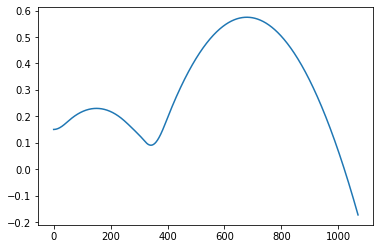

In [91]:
plt.plot(env.sim_data[2][0:env.t])
# env.action_space_y